<a href="https://colab.research.google.com/github/you444Mo/Python-Projects/blob/main/GB656_Week_7_Assignment_7_(Website_Traffic_Prediction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Website Traffic Prediction

#### Initial Setup

In [ ]:
# pip install --upgrade prophet

In [ ]:
### Import needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

import statsmodels.api as sm
import scipy.stats as st

#Time series
from statsmodels.tsa.stattools import adfuller #ADF test for stationarity
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet

#For calculating error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
### Pull in data from github repo
!git clone https://github.com/danielbauer1979/MSDIA_PredictiveModelingAndMachineLearning.git

fatal: destination path 'MSDIA_PredictiveModelingAndMachineLearning' already exists and is not an empty directory.


In [ ]:
### Read Data into DF
WebTraffic_DF = pd.read_csv("/content/MSDIA_PredictiveModelingAndMachineLearning/GB886_VII_14_logWikiPageVisits.csv")

print(WebTraffic_DF.head())
print(WebTraffic_DF.tail())

       Date  LogWikiVisits
0  12/10/07       9.590761
1  12/11/07       8.519590
2  12/12/07       8.183677
3  12/13/07       8.072467
4  12/14/07       7.893572
         Date  LogWikiVisits
2900  1/16/16       7.817223
2901  1/17/16       9.273878
2902  1/18/16      10.333775
2903  1/19/16       9.125871
2904  1/20/16       8.891374


#### Inital Data Analysis

In [ ]:
WebTraffic_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           2905 non-null   object 
 1   LogWikiVisits  2905 non-null   float64
dtypes: float64(1), object(1)
memory usage: 45.5+ KB


**<u>Note</u>:**

We have the Log of Visits in order to normalize the data and smooth out large variances amongst values.

In [ ]:
WebTraffic_DF.describe()

,LogWikiVisits
count,2905.000000
mean,8.138958
std,0.845957
min,5.262690
25%,7.514800
50%,7.997999
75%,8.580168
max,12.846747


In [ ]:
### Convert Date Field from Object Datetype to Date
WebTraffic_DF['Date'] = pd.to_datetime(WebTraffic_DF['Date'], format = 'mixed')

In [ ]:
#### View Min and Max Dates in Date
print(WebTraffic_DF['Date'].min())
print(WebTraffic_DF['Date'].max())

2007-12-10 00:00:00
2016-01-20 00:00:00


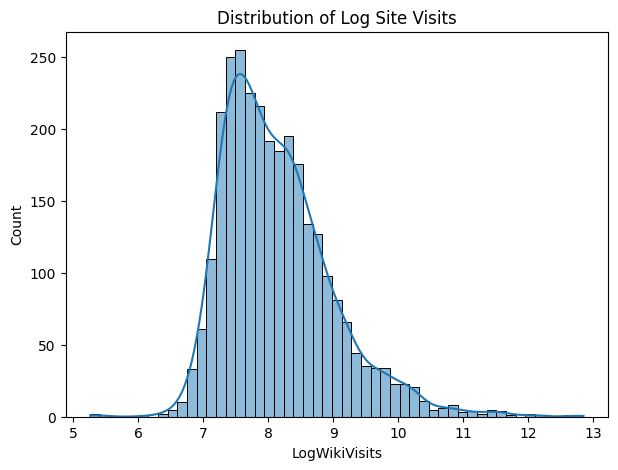

In [ ]:
### View Distriubtion of LogVists
plt.figure(figsize = (7,5))

sns.histplot(
    data = WebTraffic_DF,
    x = 'LogWikiVisits',
    kde = True
)

plt.title("Distribution of Log Site Visits")
plt.show()

**<u>Note:</u>**

Bulk of the distriubtion sits around 7.5 to 8 LogWikiVisits in a day.

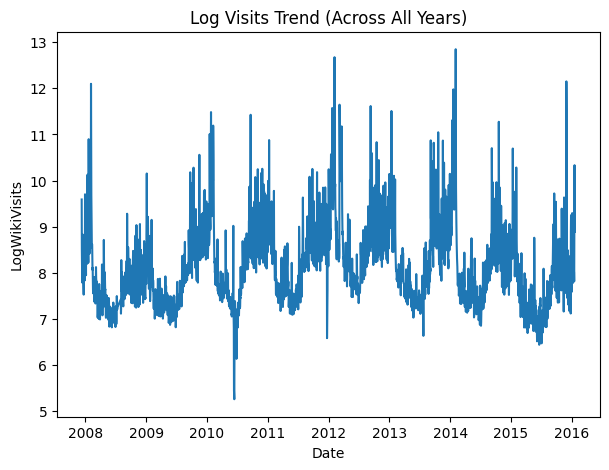

In [ ]:
### View Trend of Log Vists Across All years
plt.figure(figsize = (7,5))

sns.lineplot(
    data = WebTraffic_DF,
    x = 'Date',
    y = 'LogWikiVisits'
)

plt.title("Log Visits Trend (Across All Years)")
plt.show()

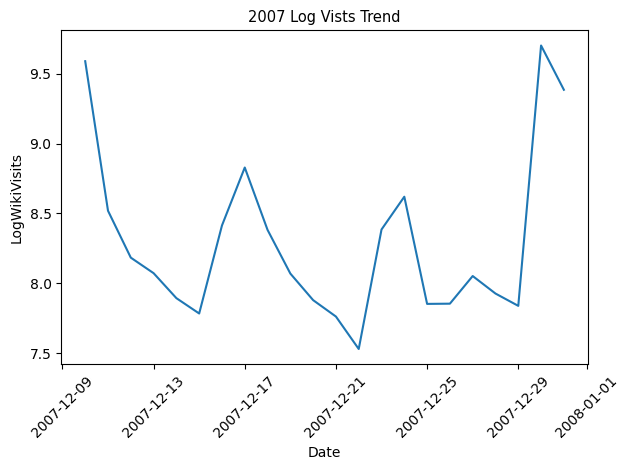

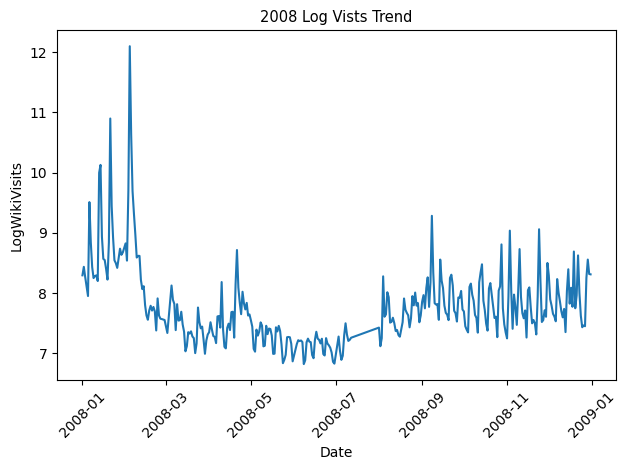

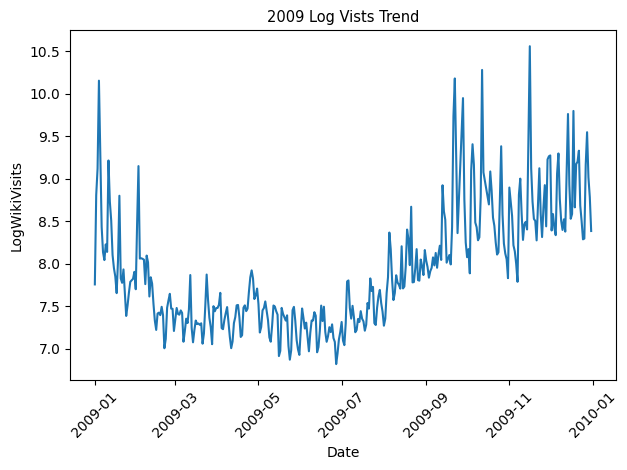

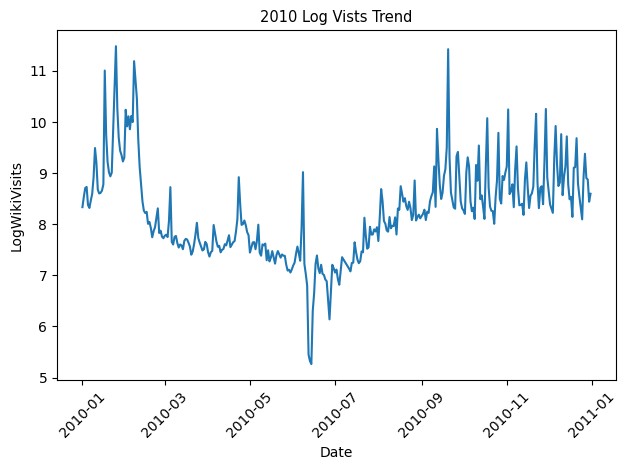

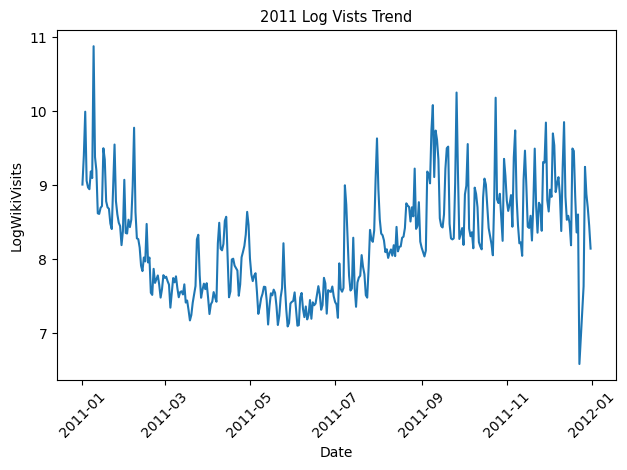

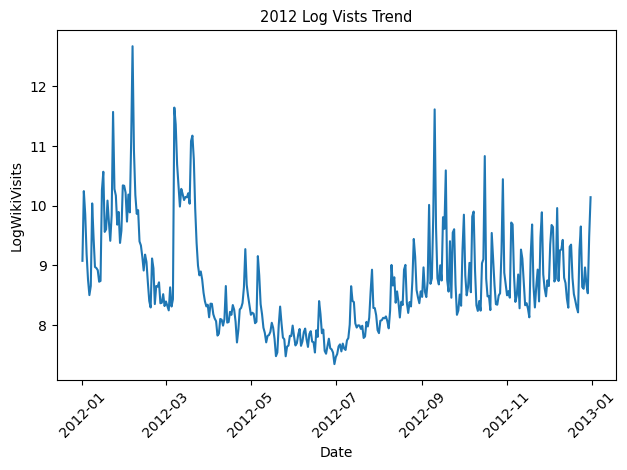

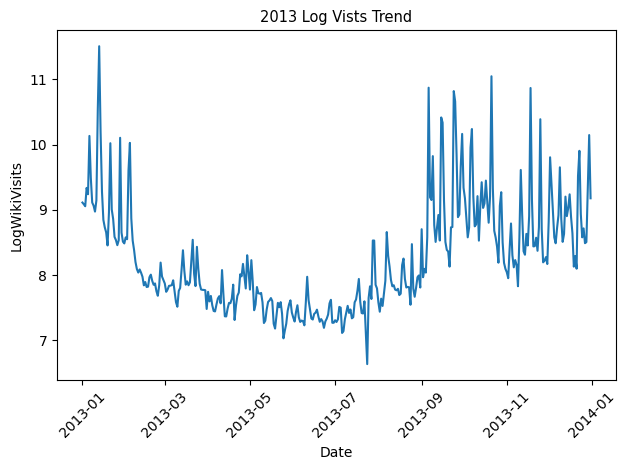

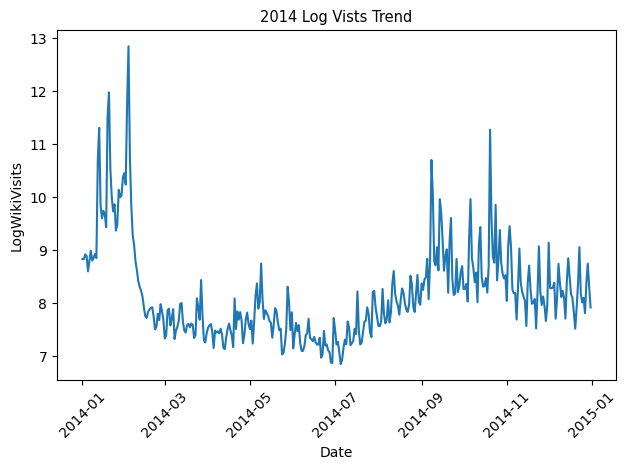

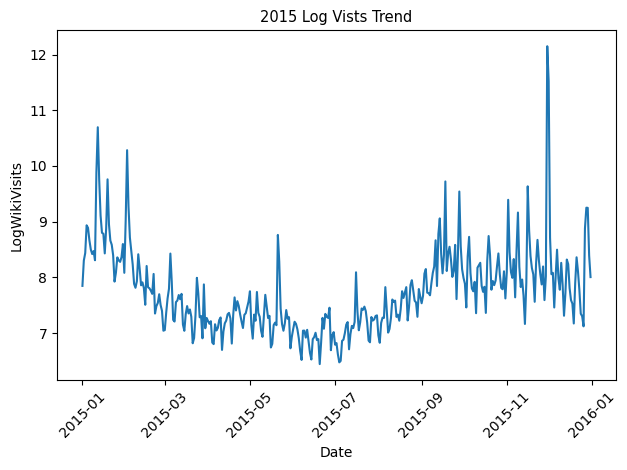

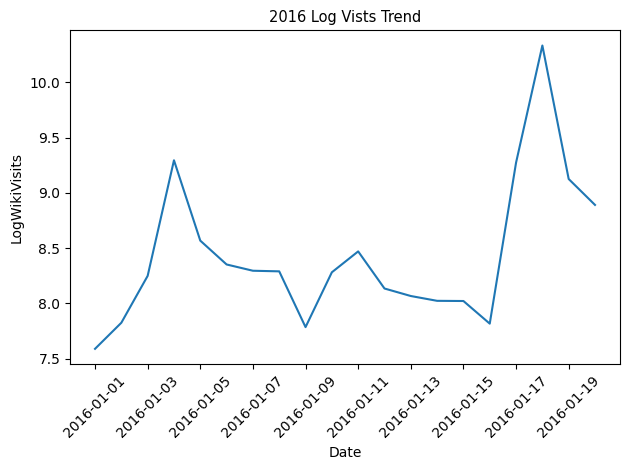

In [ ]:
### View Separate Trend of Log Visits For each year

### Add Year Field to data
WebTraffic_DF['Year'] = WebTraffic_DF['Date'].dt.year
### Store Unique Years in a List
Years_list = list(WebTraffic_DF['Year'].unique())

### Create A Timeseries plot for Each Year
for year in Years_list:

  sns.lineplot(
      data = WebTraffic_DF.query(f"Year == {year}"),
      x = 'Date',
      y = 'LogWikiVisits'
  )

  plt.xticks(rotation = 45, fontsize = 10)
  plt.title(f"{year} Log Vists Trend", fontsize = 10.5)
  plt.tight_layout()
  plt.show()
  print()

**<u>Notes:</u>**

When looking at the trend in log site vists across all years, it is a bit difficult to discern what the common trends are, although we do notice very clear dips and rises during each year. When we look at site vists from a year by year perspective though, we begin to uncover my more.

Generally, across most years we see that log site vists peak during the span of September to December, and have low points from March to July. Consitently, Website vists start off strong in the early months (Jan and Feb) and then dip continously into the spring/ early to mid-summer months.

Without knowing much about the source of our data, or what type of website it is for, I can imagine the site appeals more to colder month fall through winter-related items/activites, which would explain the constant seasonal dips in hotter months and rises during colder months in site vistis.

### Box-Jenkins Approach

#### Decomposition

In [ ]:
WebTraffic_DF.head()

,Date,LogWikiVisits,Year
0,2007-12-10,9.590761,2007
1,2007-12-11,8.519590,2007
2,2007-12-12,8.183677,2007
3,2007-12-13,8.072467,2007
4,2007-12-14,7.893572,2007


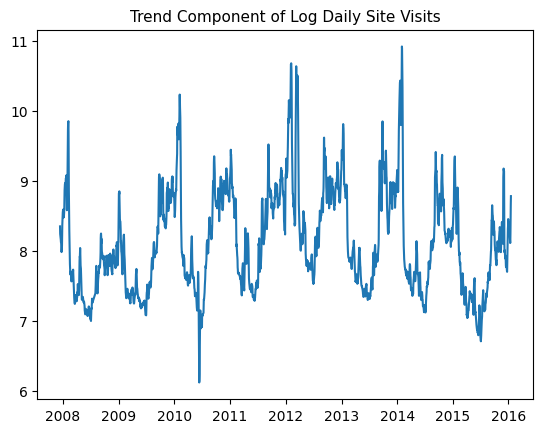

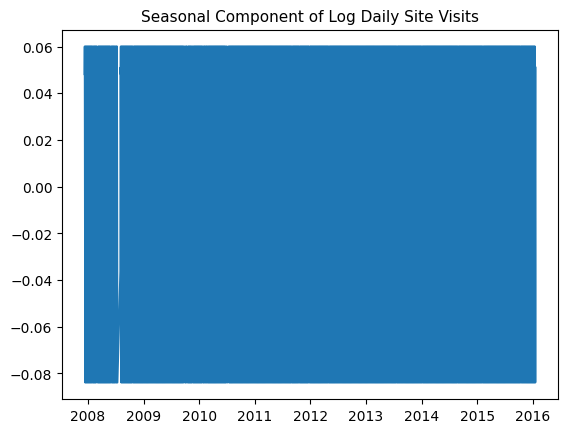

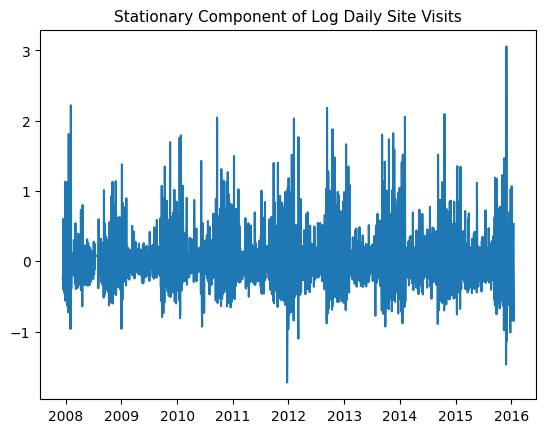

In [ ]:
### Decomposion across all years

### Decompose Data (Ensure that the index is a datetime, and only the value field is selected)
WebTraffic_Decomp = seasonal_decompose(WebTraffic_DF.set_index('Date')['LogWikiVisits'], model = 'additive', period = 7) ### Choosing 7 since data is at the daily level

### Trend Component
plt.plot(WebTraffic_Decomp.trend)
plt.title('Trend Component of Log Daily Site Visits', fontsize = 11)
plt.show()

### Seasonal Component
plt.plot(WebTraffic_Decomp.seasonal)
plt.title('Seasonal Component of Log Daily Site Visits', fontsize = 11)
plt.show()

### Stationary Component
plt.plot(WebTraffic_Decomp.resid)
plt.title('Stationary Component of Log Daily Site Visits', fontsize = 11)
plt.show()

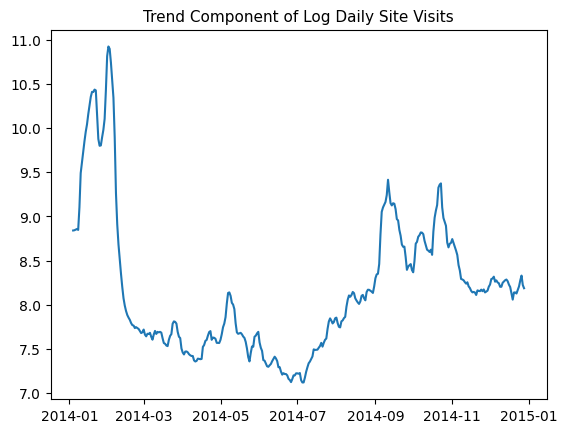

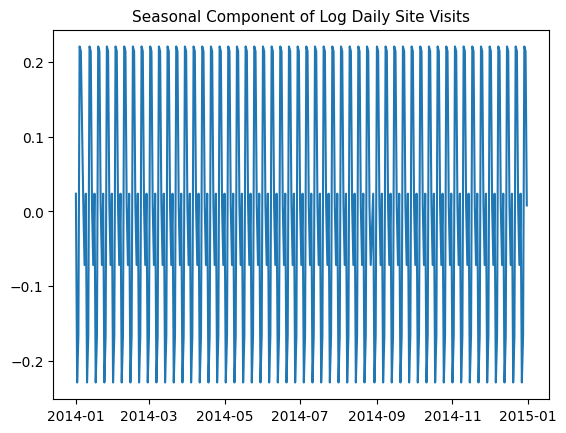

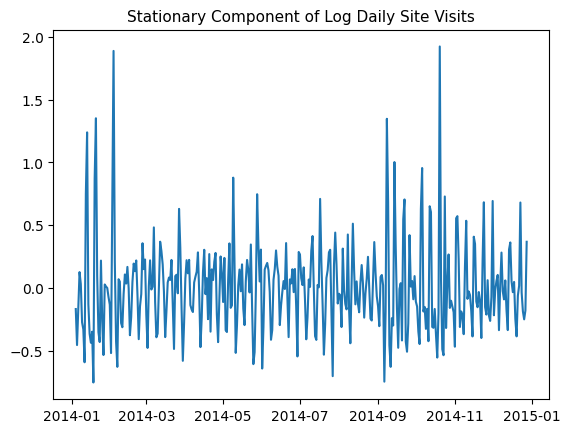

In [ ]:
### Decomposition Across 1 Year (To better display trend, seasonality, and stationary pieces being captured)

### Decompose Data (Ensure that the index is a datetime, and only the value field is selected)
WebTraffic_Decomp2014 = seasonal_decompose(WebTraffic_DF.query("Year == 2014").set_index('Date')['LogWikiVisits'], model = 'additive', period = 7) ### Choosing 7 since data is at the daily level

### Trend Component
plt.plot(WebTraffic_Decomp2014.trend)
plt.title('Trend Component of Log Daily Site Visits', fontsize = 11)
plt.show()

### Seasonal Component
plt.plot(WebTraffic_Decomp2014.seasonal)
plt.title('Seasonal Component of Log Daily Site Visits', fontsize = 11)
plt.show()

### Stationary Component
plt.plot(WebTraffic_Decomp2014.resid)
plt.title('Stationary Component of Log Daily Site Visits', fontsize = 11)
plt.show()

**<u>Notes:</u>**

We have successfuly decomposed the multi-year data to reveal the seasonal, trend, and stationary components. The eye test tells us that we have successfuly "de-trended" and extracted the stationary component from the data (the dips and falls in each year aren't very discernable now).

Out of curiousity, I performed the same decomposition technique on just 1 year's worth of data, and from this we are much more clearly able to see the various components. The Stationary component is very clearly de-trended, and the seasonal componet displays constant oscillations (most likely at the weekly level).

#### ADF Test for Stationarity

In [ ]:
result_adf = adfuller(WebTraffic_Decomp.resid.dropna())
print('ADF Statistic: %f' % result_adf[0])
print('p-value: %f' % result_adf[1])
print('Critical Values:')
for key, value in result_adf[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -18.117360
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


**<u>Notes:</u>**

Since the p-value of the ADF test is < 0.05, we reject the null hypothesis that the residual is not stationary. We now have statistical and visual evidence to prove that after removing the seasonal and trend components, we are left with stationary data.

#### ACF and PACF

We will observe both the lag and moving average (shock) components of the residual data, with the goal of observing the point in which the lags are no longer statisitcally different than 0. We experiment with various lag values until we reach that point.

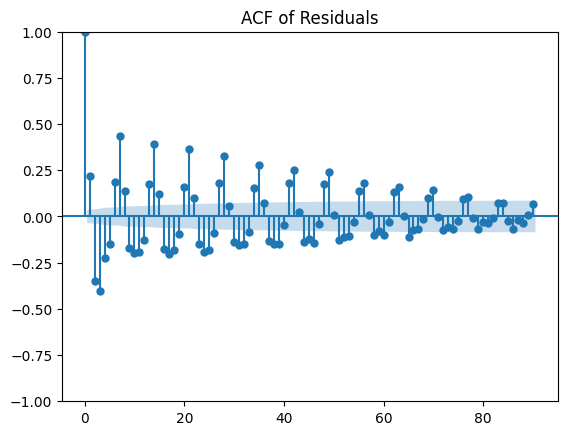

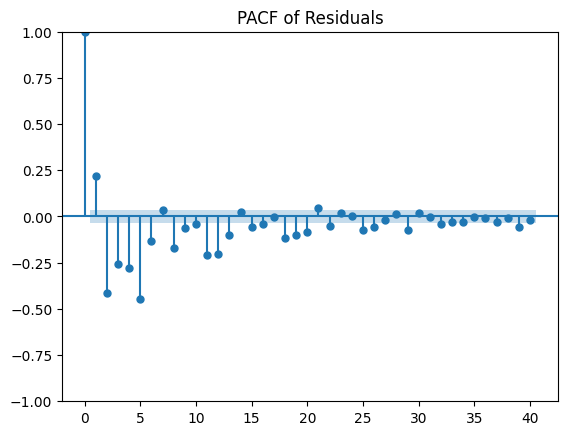

In [ ]:
plot_acf(WebTraffic_Decomp.resid.dropna(), lags = 90)
plt.title('ACF of Residuals')
plt.show()
print()
plot_pacf(WebTraffic_Decomp.resid.dropna(), lags = 40)
plt.title('PACF of Residuals')
plt.show()

**<u>Notes:</u>**

* ACF (Moving Average Term): We notice sporadic spikes up to around lag 3 before we see gradual oscillating decay to 0.

* PACF (Auto Correlation Term): We generally are noticing gradual Decay of the residuals, with the last significant spike occuring at lag 5 before the residuals don't show much autocorrelation, and eventually decay to 0.

Recommended Model: ARMA(5,3)

#### Fit ARMA Model

In [ ]:
model = ARIMA(WebTraffic_Decomp.resid.dropna(), order = (5,0,3))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                 2899
Model:                 ARIMA(5, 0, 3)   Log Likelihood                -197.908
Date:                Wed, 19 Nov 2025   AIC                            415.815
Time:                        07:13:35   BIC                            475.536
Sample:                             0   HQIC                           437.334
                               - 2899                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.011e-05    2.7e-05     -0.374      0.708   -6.31e-05    4.28e-05
ar.L1          0.3310      0.017     19.875      0.000       0.298       0.364
ar.L2         -1.0185      0.018    -55.869      0.0

**<u>Notes:</u>**

* The Ljung-Box test yields a p-value of 0.41, which means that we fail to reject  the null hypothesis that the residuals do not exhibit autocorrelation, which is what we want in this scenario since we were under the assumption that our residuals were stationary.

* AIC is sitting at 415.815, fairly low.

* We are noticing some heavy Kurtosis (7.55), indicating that the distriubtion of the residuals is fat-tailed (leptokurtic).

* JB value of 2503 suggests that the residuals aren't quite normally distributed.

* We are noticing slightly elevated Heteroskedasticity in the residuals as well (1.23), meaning the residuals do not exhibit perfect constant variance.

#### Evaluation of Residuals

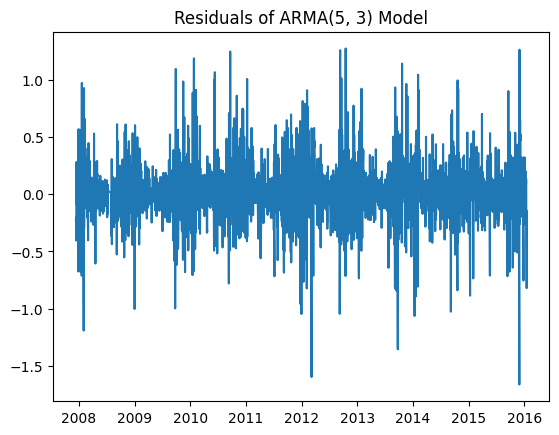

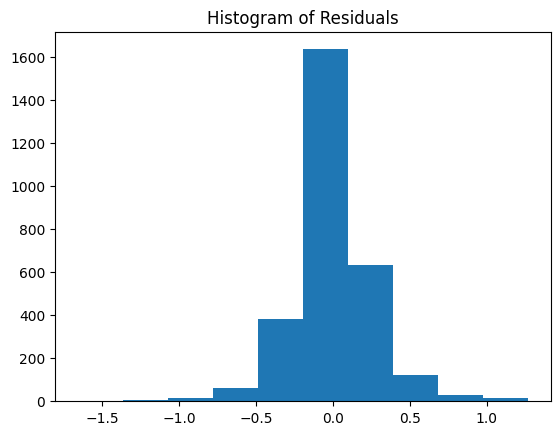

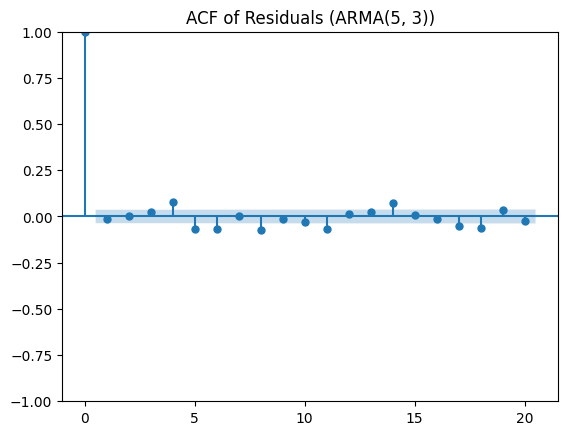

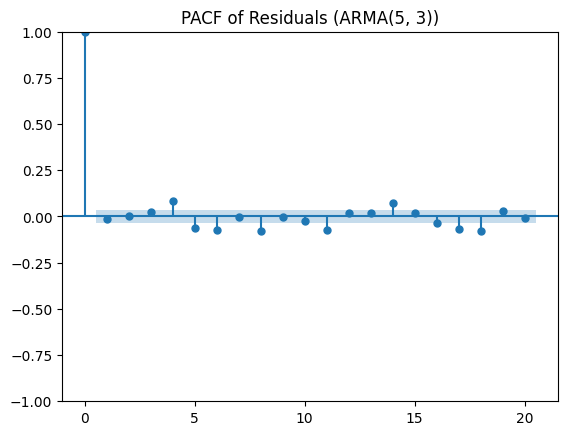

In [ ]:
residuals = results.resid

# Plot the residuals
plt.plot(residuals)
plt.title('Residuals of ARMA(5, 3) Model')
plt.show()

# Plot the histogram of residuals
plt.hist(residuals)
plt.title('Histogram of Residuals')
plt.show()

# Plot the ACF of residuals
plot_acf(residuals, lags=20)
plt.title('ACF of Residuals (ARMA(5, 3))')
plt.show()

# Plot the PACF of residuals
plot_pacf(residuals, lags=20)
plt.title('PACF of Residuals (ARMA(5, 3))')
plt.show()


**<u>Notes:</u>**

We confirm from earlier that the distribution of the residuals are non-normally distrubuted (indicated by the tall peak and fat tails of the distriubtion).

However, when looking at the ACF and PACF of the residuals, we see that generally there doesn't seem to be much in terms of autocorrelation between each lag (with the occasionaly spike just above the blue line here and there).

To conclude, this model has a good fit on the data, but, we must be cognizant of any Confidence interval calculations, as the high kurtosis could throw those calculations off a bit.

#### Model Forecasting

In [ ]:
### train test split
# All rows up to but not including the last 365 rows
WebTrafficTrainingData = WebTraffic_DF.set_index('Date')['LogWikiVisits'][:-365]
# Last 365 rows of data
WebTrafficTestingData = WebTraffic_DF.set_index('Date')['LogWikiVisits'][-365:]

print(WebTrafficTrainingData.count())
print(WebTrafficTestingData.count())

2540
365


Decompose and train the training data on ARMA(5,0,3) model

In [ ]:
decomp_train = seasonal_decompose(WebTrafficTrainingData, model='additive', period=7, extrapolate_trend='freq')

armamodel_train = ARIMA(decomp_train.resid.dropna(), order=(5, 0, 3))
fittedarma_train = armamodel_train.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Using below method to keep the forecast from exploding upward (this may "flatten out" the forecast). This grabs the last trend value from the decomposition, and deems that value the trend for all 365 predictions going forward, which accounts for possible changes in slope that can "blow up" predictions and have them trend upwards or downwards to unrealistic degrees.

In [ ]:
### Apply final trend value to all predictions
forecast_trend = np.full(365, decomp_train.trend.iloc[-1])

In [ ]:
# View Trend value
decomp_train.trend[-1]

/tmp/ipython-input-3624308997.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  decomp_train.trend[-1]


np.float64(9.825560095943871)

Use the past 365 days to forecast for the next 365 days (utilize 7-day seasonal component)

In [ ]:
# Use last 365 days of seasonal pattern
# forecast_seasonal = decomp_train.seasonal[-365:].values

# --- 7-day seasonal component ---
# Extract last full weekly cycle (7 values)
weekly_cycle = decomp_train.seasonal[-7:].values

# Repeat it enough times to cover 365 days
forecast_seasonal = np.tile(weekly_cycle, 53)[:365]



Finally, we forecast our ARMA(5,3) model and combine the three components plus the confidence interval from the ARMA model to get our total forecasts:

In [ ]:
### Creation of central forecasts and Confidence Intervals
forecast_arma = fittedarma_train.predict(start=len(decomp_train.resid.dropna()), end=len(decomp_train.resid.dropna()) + 364)
forecast = forecast_trend + forecast_seasonal[:365] + forecast_arma.values

forecast_arma_ci = fittedarma_train.get_forecast(steps=365).conf_int()
forecast_lower = forecast_trend + forecast_seasonal + forecast_arma_ci.iloc[:, 0].values
forecast_upper = forecast_trend + forecast_seasonal + forecast_arma_ci.iloc[:, 1].values

# Create a DataFrame for the forecast with confidence intervals
forecast_df = pd.DataFrame({'Forecast': forecast,
                           'Lower Bound': forecast_lower,
                           'Upper Bound': forecast_upper},
                          index=WebTrafficTestingData.index)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
forecast_df['Actual'] = WebTrafficTestingData.values

In [ ]:
### Show Central Forecasts with Confidence Intervals
forecast_df

,Forecast,Lower Bound,Upper Bound,Actual
Date,,,,
2015-01-19,11.472494,10.961937,11.983050,9.759386
2015-01-20,11.524050,11.003006,12.045094,8.952088
2015-01-21,10.587133,9.966829,11.207436,8.661120
2015-01-22,9.668833,8.990201,10.347465,8.584852
2015-01-23,9.070733,8.391609,9.749857,8.396606
...,...,...,...,...
2016-01-16,9.843231,9.068312,10.618151,7.817223
2016-01-17,9.807751,9.032831,10.582670,9.273878
2016-01-18,9.716715,8.941795,10.491634,10.333775


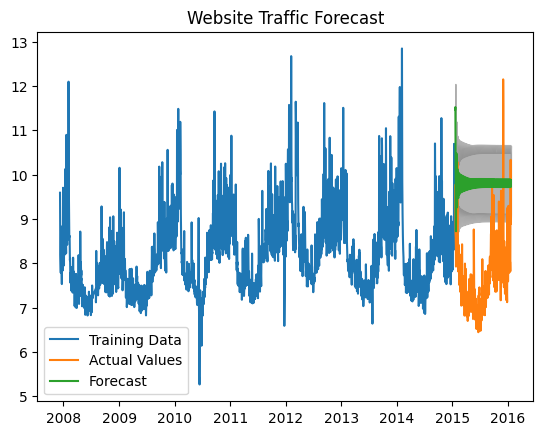

In [ ]:
plt.plot(WebTrafficTrainingData, label='Training Data')
plt.plot(WebTrafficTestingData, label='Actual Values')
plt.plot(forecast_df['Forecast'], label='Forecast')
plt.fill_between(forecast_df.index, forecast_df['Lower Bound'], forecast_df['Upper Bound'], color='gray', alpha=0.6)
plt.legend()
plt.title('Website Traffic Forecast')
plt.show()

We see a "flatted out" forecast that lies close to that of the last training value. It doesn't follow the volatility of the actual data, but it provides us with a reasonable estimate for the future, without grossly over or underestimating forecast values due to changes in slope.

#### Evaluation

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(WebTrafficTestingData, forecast_df['Forecast']))
print('RMSE:', rmse)

# Calculate MAE
mae = mean_absolute_error(WebTrafficTestingData, forecast_df['Forecast'])
print('MAE:', mae)

# Calculate MAPE
mape = np.mean(np.abs((WebTrafficTestingData.values.flatten() - forecast_df['Forecast'].values))/WebTrafficTestingData.values.flatten()) * 100
print('MAPE:', mape)

RMSE: 2.2327277225516404
MAE: 2.1394068002909403
MAPE: 28.578193443141252


We see a MAPE of 28.57, which is relatively high (ideally, we would like this value to sit below 10).

### Prophet

#### Data Setup

In [ ]:
### Create Copy of df for modeling using Prophet
WebTrafficDF_Prophet = WebTraffic_DF.copy()

Get df into useable form for profit

In [ ]:
WebTrafficDF_Prophet.drop(columns = ['Year'], inplace = True)

WebTrafficDF_Prophet.rename(columns= {
    'Date' : 'ds',
    'LogWikiVisits' : 'y'
    }, inplace = True
)

#### Model Fitting

In [ ]:
### Fit model using Prophet
time_series = Prophet()
time_series.fit(WebTrafficDF_Prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
### Define future days
future = time_series.make_future_dataframe(periods=365,freq='D') ### Define future as next 365 days
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


#### Forecasting

In [ ]:
### Forecast future
forecast = time_series.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.211588,7.501412,8.919911
3266,2017-01-16,8.536648,7.788457,9.281068
3267,2017-01-17,8.324075,7.639772,9.063140
3268,2017-01-18,8.156719,7.438365,8.849788
3269,2017-01-19,8.168652,7.466305,8.886431


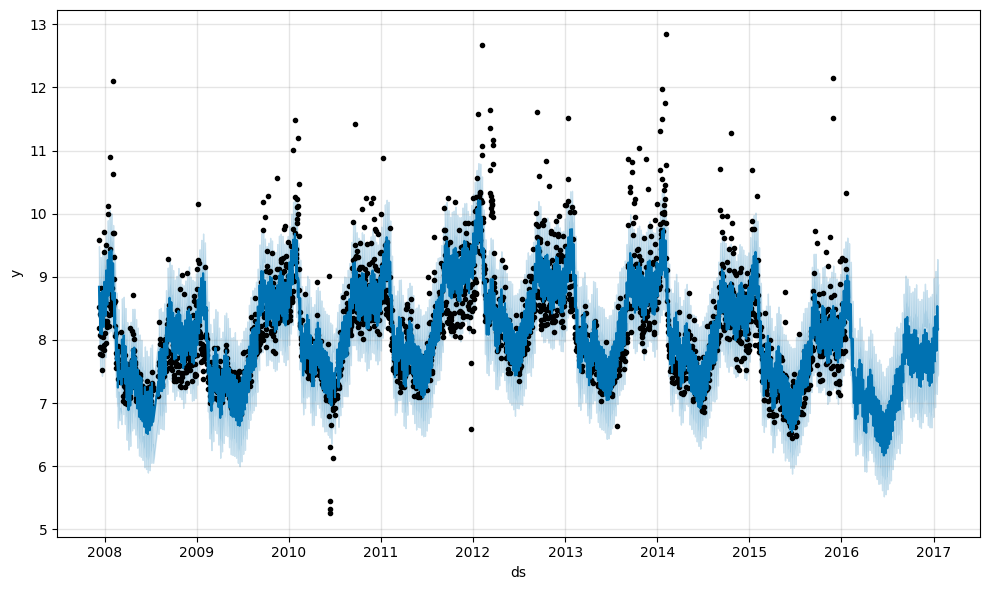

In [ ]:
### Plot forecast on historical data
prophet_fig_1 = time_series.plot(forecast) ### The end point of the trend is our forecast(without the dots) (includes confidence intervals)

We see a much more precise fit here vs the manual Box-Jenkins approach taken before, where we applied a "smoothing effect" to our trend that flattened out our forecast. Prohpet was able to exactly match the volatility of the historical data in its forecast.

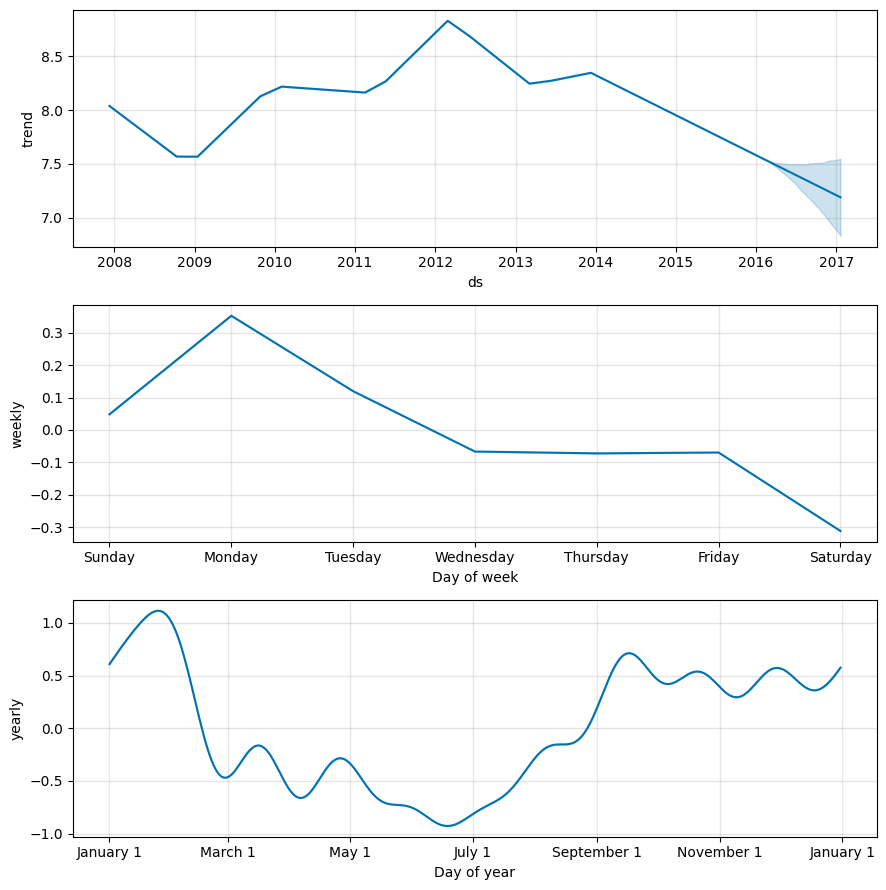

In [ ]:
### extracting the seasonal and trend pieces
prophet_fig_2 = time_series.plot_components(forecast) ### Shows trend and seasonality components

Shows us both yearly and weekly trends

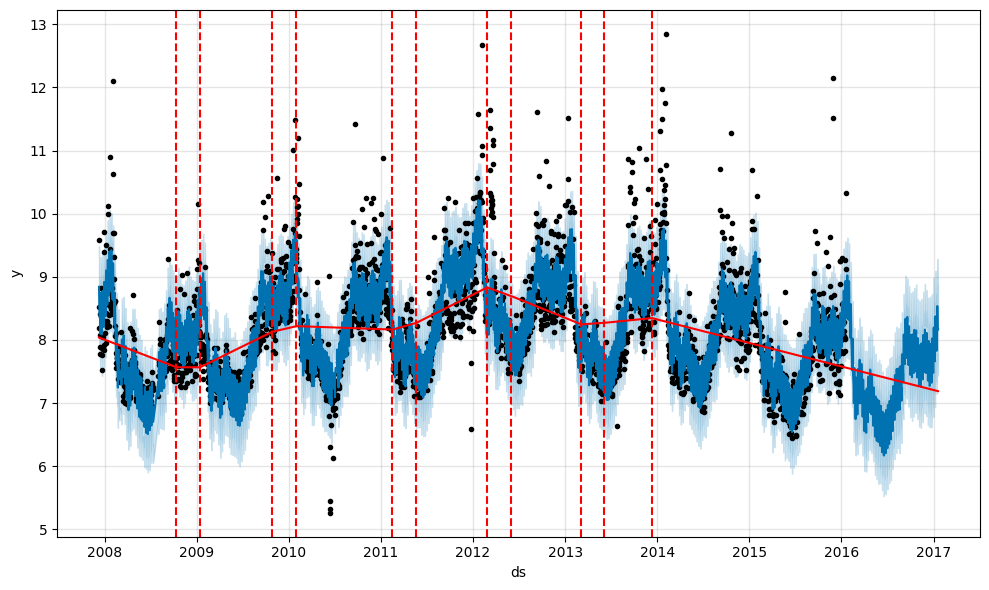

In [ ]:
# See change points in data
from prophet.plot import add_changepoints_to_plot
fig = time_series.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), time_series, forecast)

We can see major chainging points in the forecast being marked here. We notice that a bulk of these points occur early to mid year, each year.

#### Evaluation

In [ ]:
from prophet.diagnostics import cross_validation ### Windowed cross validation
df_cv = cross_validation(time_series, initial='1460 days', period='180 days', horizon = '365 days')
#You can adjust the windows---here we use three years initially and then various windows thereafter

INFO:prophet:Making 7 forecasts with cutoffs between 2012-02-05 00:00:00 and 2015-01-20 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-02-06,9.725058,9.171226,10.238982,12.673542,2012-02-05
1,2012-02-07,9.477620,8.899780,10.052831,10.924697,2012-02-05
2,2012-02-08,9.233795,8.694834,9.752323,10.181536,2012-02-05
3,2012-02-09,9.145756,8.584035,9.708631,9.863394,2012-02-05
4,2012-02-10,9.078897,8.552975,9.642166,9.925738,2012-02-05
...,...,...,...,...,...,...
2540,2016-01-16,8.579966,7.836292,9.309480,7.817223,2015-01-20
2541,2016-01-17,8.974615,8.256470,9.686124,9.273878,2015-01-20
2542,2016-01-18,9.280753,8.572902,9.956677,10.333775,2015-01-20
2543,2016-01-19,9.063898,8.360479,9.789198,9.125871,2015-01-20


In [ ]:
#### Prophet Error Metrics
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
324,361 days,0.722584,0.850050,0.724026,0.089569,0.081204,0.087299,0.561867
325,362 days,0.725726,0.851896,0.726035,0.089567,0.080965,0.087305,0.563555
326,363 days,0.732912,0.856103,0.728152,0.089574,0.081204,0.087271,0.560180
327,364 days,0.745182,0.863239,0.732033,0.089960,0.081274,0.087608,0.556243
328,365 days,0.765602,0.874987,0.741838,0.090978,0.082215,0.088632,0.550619


/usr/local/lib/python3.12/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


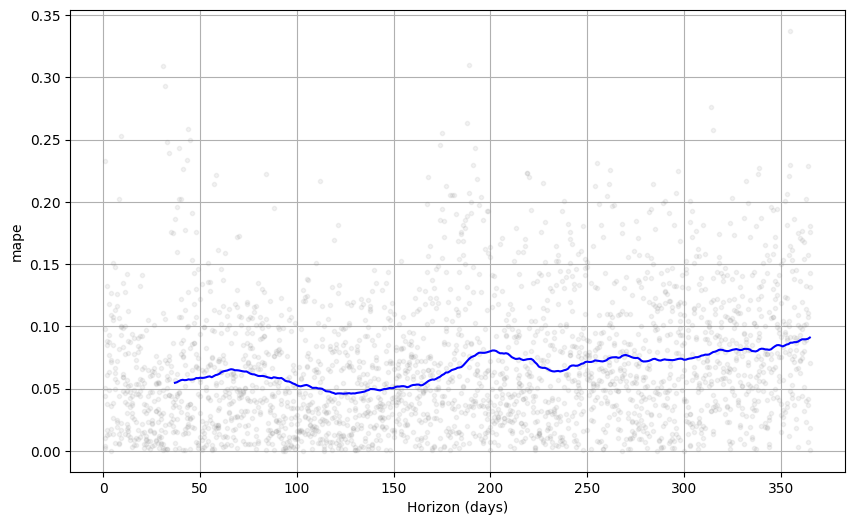

In [ ]:
### Time Horizone vs MAPE
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

The MAPE increases the farther we go predict into the future, but still sits below 10% even at the 365 day mark, which is a great sign in terms of model accuracy.

## Final Notes

Overall, the Prophet model outperformed my Manual Box Jenkins apporach by a considerable margin (MAPE of 28.57 vs Prophet's MAPE estimations using cross validation (all below 10%).

From a forecasting fit persepective, we see that the Prophet model was able to fit a much better/more beliveable forecast on the data vs what my model could produce. My model was able to give a good estimate for the direction of the forecast, but could not ultimately capture the volatility of the historical data in its estimate.

With more time and tuning, I'm sure I can get my model to perform up to the level of the one that Prophet was able to produce. With that being said, It is quite impressive how packages like prophet can simplify complex processes like this to just a few lines of code, and in less time.